**Gaussian Processes for circuitpython**

Funktioniert ganz gut. Also Theoretisch kann man alle Funktionen mit Hilfe der numpy Funktionen aus der reduzierten circuitpython Version mehr oder weniger nachschreiben.

Blöderweise bekomme ich aber so ein komisches Rauschen rein. Das müsste an der cholesky transfomation in sample_multivariante_normal_1d liegen. Ich bin mir aber nicht sicher.

Komisch ist aber, dass es im Test rauschfrei funktioniert und erst im gaussian process rauscht. Das spricht dann eher fürs Invertieren der Matrix in gp_prediction... ok, ich denke das könnte es eher sein.

Ansonsten bräcuhten wir noch einen Ersatz für from scipy.spatial.distance import cdist oder eine andere geeignete Kernelfunktion, die schöne Dinge macht.

**more elegant implementation**

i think the noise comes from gauss sampling... yes Idiot!

In [14]:
from numpy.linalg import inv
#from gaussian_processes_util import plot_gp
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

def box_muller_1d(dummy):    
    #np.random.seed(521)
    U1 = np.random.uniform(size = dummy)
    U2 = np.random.uniform(size = dummy)
    R = np.sqrt(-2 * np.log(U1))
    Theta = 2 * np.pi * U2
    X = R * np.cos(Theta)
    Y = R * np.sin(Theta)
    return X

def sample_gauss_box_mueller_1d(mu,sigma,size):
    print("this is box mueller")
    xx = np.vectorize(box_muller_1d)
    # use this for tests... box muller is faster
    #print("this is box sampleN_v1")
    #xx = np.vectorize(sampleN_v1)
    return xx(size) * sigma + mu

def sample_multivariante_normal_1d(mu,K,epsilon=1e-100):
    d = len(mu)
    Kx = K + epsilon#*np.eye(d)
    L = np.linalg.cholesky(Kx)
    #L = scipy.linalg.cholesky(Kx)
    u = sample_gauss_box_mueller_1d(0, 1, d )
    return mu.transpose() + np.dot(L, u)

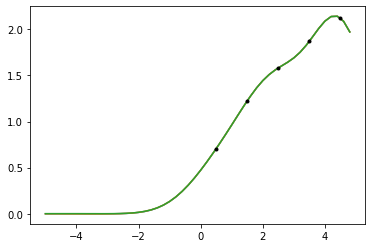

this is box mueller


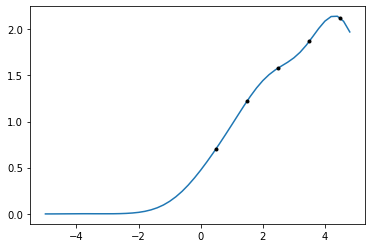

In [16]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
#plot_gp(mu, cov, X, samples=samples)

# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

X_train = np.arange(0.5,5).reshape(-1, 1)
Y_train = np.sqrt(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, l=1.0, sigma_f=.0010, sigma_y=1e-8)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
#plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


plt.plot( np.squeeze(X), samples.T )
plt.plot(np.squeeze(X_train),np.squeeze(Y_train),".k")
plt.show()

samples_1d  = sample_multivariante_normal_1d(mu_s.ravel(), cov_s)

plt.plot( np.squeeze(X), samples_1d.T )
plt.plot(np.squeeze(X_train),np.squeeze(Y_train),".k")
plt.show()

**Euclidean Distance**

...is missing :/
...and nice :)
For rbf_kernel... oder einen ebenfalls geeigneten Kernel suchen...

In [ ]:
a = np.array([[1,1,1,1],[1,2,3,4]])
np.linalg.norm( [1,2] )

In [ ]:
c = [(35.0456, -85.2672),
          (35.1174, -89.9711),
          (35.9728, -83.9422),
          (36.1667, -86.7833)]

c = [ [1,2,3,5], [2,2,3,4], [2,2,3,4] ]
cdist(c,c)

In [ ]:
np.linalg.norm( [1,2] )

In [ ]:
np.sqrt( (1-2)**2 )

In [ ]:
np.sqrt( sum( [  (a-b)**2 for a,b in zip(c[0] , c[1]) ] ))

**Glätten**

convolution... not necessary anymore :)

In [ ]:
np.convolve(  np.array([1, 1, 5, 5,6,6,7,7]),np.array([1]) , mode='same')

**gaussian distribution tests**

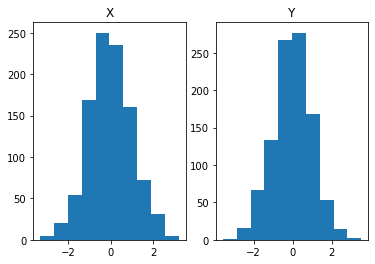

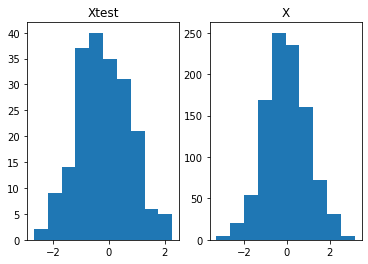

In [17]:
np.random.seed(521)
U1 = np.random.uniform(size = 1000)
U2 = np.random.uniform(size = 1000)
R = np.sqrt(-2 * np.log(U1))
Theta = 2 * np.pi * U2
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

fig,(ax1,ax2) = plt.subplots(1,2)
temp = ax1.hist(X)
ax1.set_title("X")
temp = ax2.hist(Y)
ax2.set_title("Y")
plt.show()

test =  box_muller_1d(200)




fig,(ax1,ax2) = plt.subplots(1,2)
temp = ax1.hist(test)
ax1.set_title("Xtest")
temp = ax2.hist(X)
ax2.set_title("X")
plt.show()